<a href="https://colab.research.google.com/github/farhanwadia/steel_defect_detection/blob/main/Steel_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing Kaggle Data**

---



In [ ]:
#Link to competition: https://www.kaggle.com/c/severstal-steel-defect-detection/overview
#First download the kaggle.json file (link: https://drive.google.com/file/d/10sAnRwhuwetq-6Chjpaum__1Vh5-6Nu9/view?usp=sharing) then re-upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhanwadia","key":"2c92598698ee94f469567eb3af100ca4"}'}

In [ ]:
#Mount the kaggle.json file
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 67 Dec  4 23:32 kaggle.json


In [ ]:
#Extract required files
!kaggle competitions download -c severstal-steel-defect-detection -q
!unzip -q train.csv.zip
!unzip -q train_images.zip -d train_images

In [ ]:
# Mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Include all import statements required over here
import csv
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image, ImageDraw
import math
import os
import shutil
import random
import cv2
from scipy import ndimage, misc
import itertools
from skimage import io, transform
import time
import zipfile

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, utils, models

**List of global variables used in the file and their purpose (update as needed)**

`trainingDataPath` : path to the train.csv file

`data` : array extracted from train.csv file

`filenameAndClassIndex` : dictionary with all `ImageId_ClassId` strings from train.csv file as keys (e.g. '002cc93b.jpg_1') and row position in `data` as values (e.g. 1).  Use it to index `data` by filename (e.g. to get encodedPixels for a filename and known class) 

`numInClassCounter` : An array of counters for the number of images with defects in each class. `numInClassCounter[0]` is the number of images w/ no defects, `numInClassCounter[1]` is the number of images w/ class 1 defects... 

`filenamesByClass` : a 2D list where the first dimension corresponds to the classID (0: No defects, ..., 4: Class 4) and the second dimension is a list of filenames with **any** defects in that class

`uniqueFilenamesByClass` : a 2D list where the first dimension corresponds to the classID (0: No defects, ..., 4: Class 4) and the second dimension is a list of filenames that **only** have defects in that one class

`numClasses = 5`

`default_resize_width = 800` 

`default_resize_height = 128`

# **2. Import the dataset**

---



In [ ]:
#Load the dataset and list of filenames

def removeDuplicates(lst):
    #Remove duplicate values from a list
    return list(dict.fromkeys(lst))

#Returns the run-length encoded pixels for a filename and given classID from 1 to 4
def getEncodedPixels(filename, classID):
    return data[filenameAndClassIndex[filename + "_" + str(classID)]][1]

#Load train.csv as a list
trainingDataPath = "/content/train.csv"
with open(trainingDataPath, 'r') as file:
    data = list(csv.reader(file, delimiter=","))

filenameAndClassIndex = {} #dictionary to index data array based on first column's value (ImageId_ClassId)   
filenames = []

for i in range(1, len(data)):
    filenameAndClassIndex[data[i][0]] = i
    filenames.append(data[i][0].split("_")[0])
filenames = removeDuplicates(filenames) # remove duplicates from the list of filenames

#Get the number of images with defects in each class

#numInClassCounter[0] is the number of images w/ no defects, numInClassCounter[1] is the number of images w/ class 1 defects... 
#filenamesByClass is a 2D list. The first dimension corresponds to the classID (0: No defects, ..., 1: Class 1, 4: Class 4)

numClasses = 5
numInClassCounter = [0, 0, 0, 0, 0]
filenamesByClass = [[], [], [], [], []]
for img_file in filenames:
    noDefects = True
    for classID in range(1,5):
        if getEncodedPixels(img_file, classID) != '': 
              numInClassCounter[classID] += 1 
              filenamesByClass[classID].append(img_file)
              noDefects = False
    if noDefects:
        numInClassCounter[0] +=1
        filenamesByClass[0].append(img_file)

In [ ]:
#Helper functions for image processing

def getImage(filename):
    #returns a PIL Image object of the image with name 'filename'
    os.chdir("/content/train_images")
    picture = Image.open(filename)
    os.chdir("/content")
    return picture

def imageToRGBArray(img):
    #returns an array of RGB pixel values based on the inputted PIL image object
    #Format is length, width, channels   
    arrayRGB = np.array(img)
    return arrayRGB

def RGBToGrey(arrayRGB):
    #returns a 1D np array of greyscale values given a 3D np array of RGB values
    arrayGrey =  0.2989 * arrayRGB[:, :, 0] + 0.5870 * arrayRGB[:, :, 1] + 0.1140 * arrayRGB[:, :, 2]
    return arrayGrey

def getOneClassFilenames(classID, filenamesByClass):
    #gets a list of filenames that are only in one class and not in multiple classes
    for i in range(5):
        others = set()
        if i != classID:
            #Get a union of all the image names not in the class
            others = others.union(set(filenamesByClass[i]))
    return list(set(filenamesByClass[classID]).difference(others)) #only keep the filenames not in others

def averagePixelIntensities(filenames):
    #Takes in a list of string filenames, gets their images, greyscales them, and averages them at each element in the array. 
    #Returns a 2D np array. Use this only for the histogram
    return sum([RGBToGrey(imageToRGBArray(getImage(f))) for f in filenames]) / len(filenames)

# Helper function to paint a picture object given the run-length encodedPixels and RGBA colour tuple. Returns the PIL picture object again
#i.e. pic = Image.open(file)
def applyMask(pic, encodedPixels, colour): 
    encodedPixelsList = encodedPixels.split()
    picWidth, picHeight = pic.size
    numPixels = picWidth * picHeight
    
    for j in range(0, len(encodedPixelsList), 2): #iterate over locations within encodedPixels (every other value)
        draw = ImageDraw.Draw(pic, 'RGBA')
        for k in range(1, int(encodedPixelsList[j+1]) + 1): #create range of the size that is the number of pixels to paint
            pixelNum = int(encodedPixelsList[j]) + k - 1
            xPos = math.floor(pixelNum / picHeight)
            yPos = pixelNum % picHeight
            draw.point((xPos, yPos), colour)
    return pic

def saveImage(image_PIL, filename_string):
    #Saves a PIL image to the "/content" directory with the inputted filename
    os.chdir("/content")
    image_PIL.save(filename_string + ".png")

def imgHistogramEqualization(image, number_bins=256):
    #taken from https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy
    #takes in an np array of an image and returns a list where element [0] is the histogram equalization of the image, and element[1] is the distribution function

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

def thresholdImg(img, threshold = 0.5):
    #takes in an np array of an image and returns the np array with numbers below the threshold % set to 0, and numbers above to 1
    thrImg = np.where(img >= threshold * 255, 1, img)
    thrImg = np.where(img < threshold * 255, 0, img)
    return thrImg

def gaussianLaplaceImg(img):
    return ndimage.gaussian_laplace(img, sigma=1)

def sobelImg(img):
    return ndimage.sobel(img)

In [ ]:
#Get a list of filenames which only have 1 class of defect. First dimension is the class, second dimension is the list.
#These files will be used to create the histogram
uniqueFilenamesByClass = []
for i in range(5):
    uniqueFilenamesByClass.append(getOneClassFilenames(i, filenamesByClass))

# **3. Data Exploration**

---



**3.1 - Descriptive Statistics**


In [ ]:
for i, num in enumerate(numInClassCounter):
    print("There are", num, "images that have defects belonging to class", i)

There are 5902 images that have defects belonging to class 0
There are 897 images that have defects belonging to class 1
There are 247 images that have defects belonging to class 2
There are 5150 images that have defects belonging to class 3
There are 801 images that have defects belonging to class 4


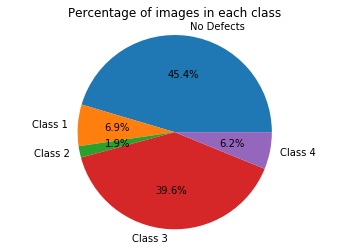


 There are 12568 images in total


In [ ]:
#Plot a pie chart
labels = ["No Defects", 'Class 1', 'Class 2', 'Class 3', 'Class 4']
plt.pie(numInClassCounter, labels=labels, autopct='%1.1f%%', shadow=False)
plt.axis('equal')  
plt.title("Percentage of images in each class")
plt.show()

print("\n There are", len(filenames), "images in total")

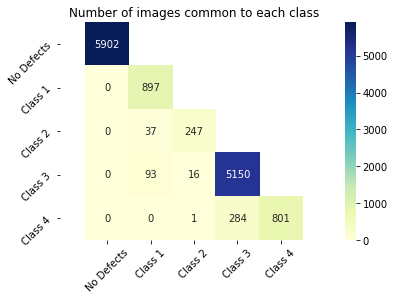

In [ ]:
#Visualize how many images are common between two classes i and j. Note that images can potentially have more than two defect classes, but that is more complicated to visualize
commonalityMatrix = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        numFilesInCommon = len((set(filenamesByClass[i]) & set(filenamesByClass[j])))
        commonalityMatrix[i, j] = int(numFilesInCommon)

mask = np.zeros_like(commonalityMatrix, dtype=np.bool)
mask[np.triu_indices_from(commonalityMatrix, k = 1)] = True

sn.heatmap(commonalityMatrix, cmap="YlGnBu", annot=True, xticklabels = labels, yticklabels = labels, fmt='g', mask = mask)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.axis('equal') 
plt.title("Number of images common to each class")
plt.show()

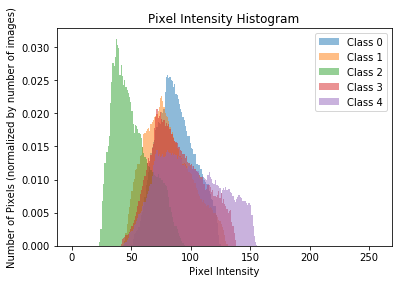

In [ ]:
#Plot pixel histograms of images for the different defect classes
#Plot a histogram of pixel intensity distributions, where each class' "image" is computed using averagePixelIntensities().
#Do not run this if the histogram is already there; takes a while!
for i in range(5):
    classImage = averagePixelIntensities(uniqueFilenamesByClass[i])
    plt.hist(classImage.ravel(), density = True, bins=256, range=(0, 256), alpha = 0.5, label = "Class " + str(i)) #density = True normalizes the area to one for each histogram

plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels (normalized by number of images)')
plt.legend(loc='upper right')
plt.show()

**3.2 - Visualizing defects and exploring pre-proccessing filters**

3.2.1 - Example images without any processing

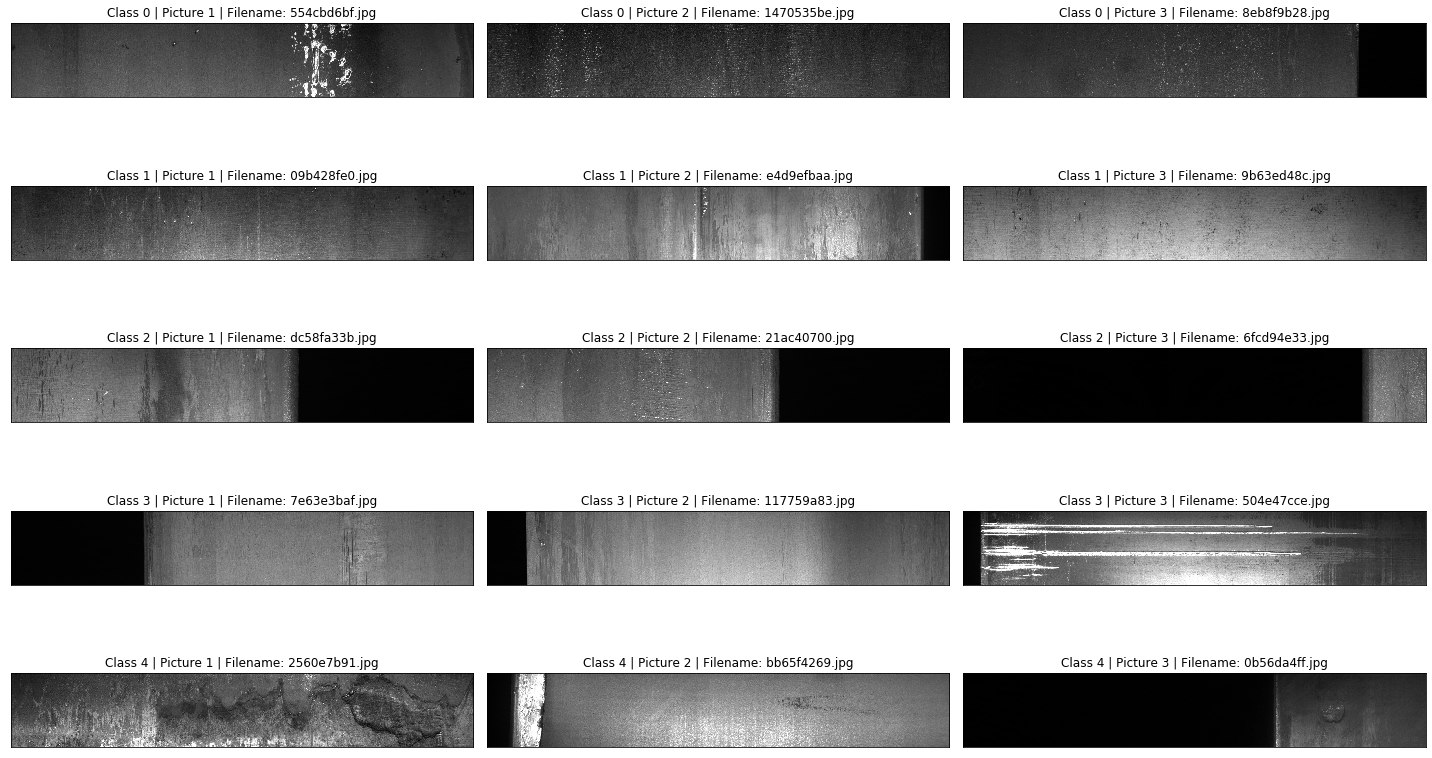

In [ ]:
#Look at a few images to try and identify the defects
#Plot a few images from each class without any masks
pltFilenames = []

numImagesPerClass = 3

fig, axs = plt.subplots(numClasses, numImagesPerClass, figsize=(numClasses*4,numImagesPerClass*4))

for i in range(numClasses):
    for j in range(numImagesPerClass): 
        #choose a random image with only one defect for each class 
        random.seed(i+j+21)
        pltFilenames.append(uniqueFilenamesByClass[i][random.randint(0, len(uniqueFilenamesByClass[i]))])
        
        filename = pltFilenames[-1]

        #Plot the image as is
        img = RGBToGrey(imageToRGBArray(getImage(filename)))
        axs[i, j].imshow(img, cmap = "gray")
        axs[i, j].set_title("Class " + str(i) + " | Picture " + str(j+1) + " | Filename: " + str(filename))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()

3.2.2 - Example images with ground-truth pixel defect masks applied in red

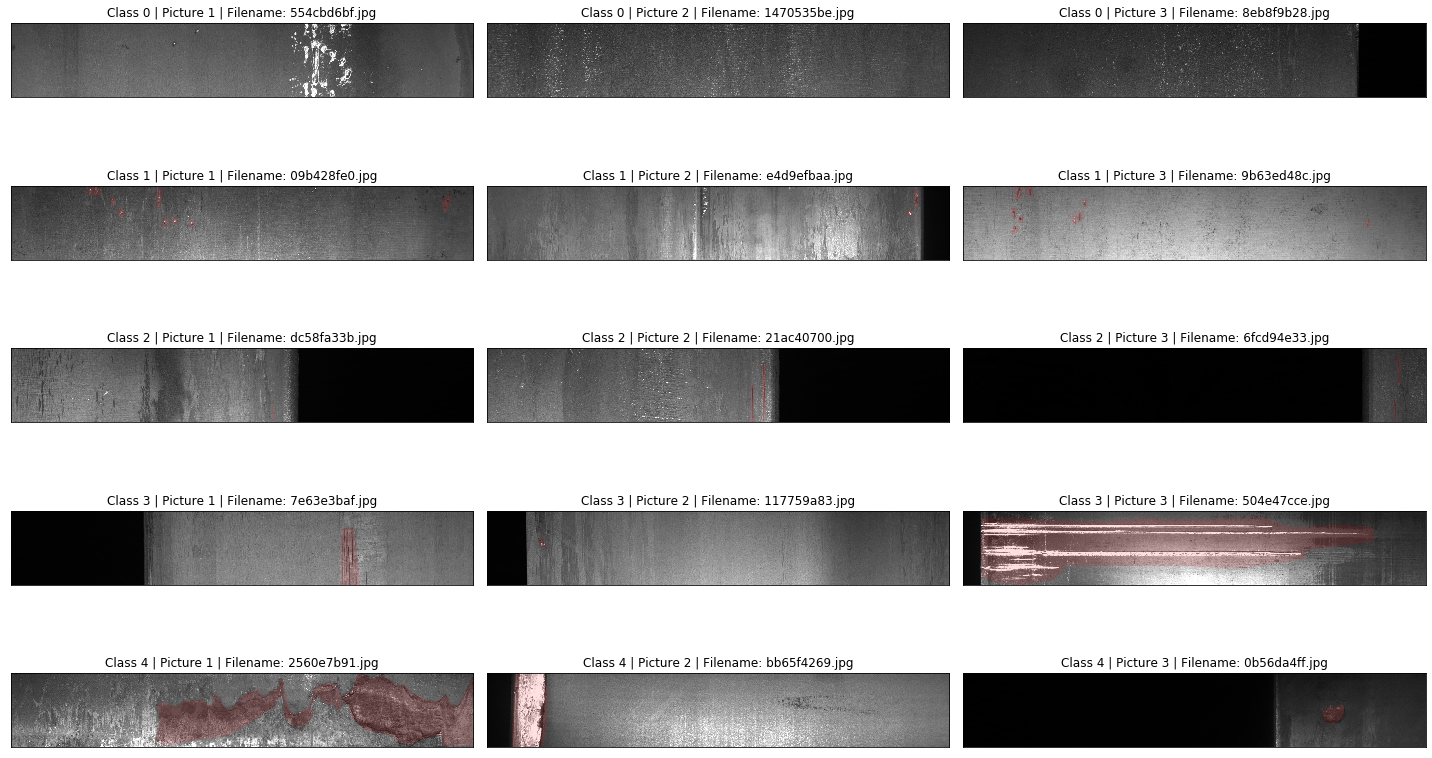

In [ ]:
#Plot the same images from above, but with masks to see what the defects are
fig, axs = plt.subplots(numClasses, numImagesPerClass, figsize=(numClasses*4,numImagesPerClass*4))
filenameIter = iter(pltFilenames)
for i in range(numClasses):
    for j in range(numImagesPerClass): 
        #Plot the image with a defect mask applied
        filename = next(filenameIter)
        if i != 0:
            if getEncodedPixels(filename, i) != "": #apply the mask only if there is a value of encodedPixels
                img = imageToRGBArray(applyMask(getImage(filename), getEncodedPixels(filename, i), (255, 0, 0, 30)))
        else:
            #If no mask (i.e. class 0), just plot the image
            img = imageToRGBArray(getImage(filename))
        
        axs[i, j].imshow(img)
        axs[i, j].set_title("Class " + str(i) + " | Picture " + str(j+1) + " | Filename: " + str(filename))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()

3.2.3 - Example images processed with histogram equalization

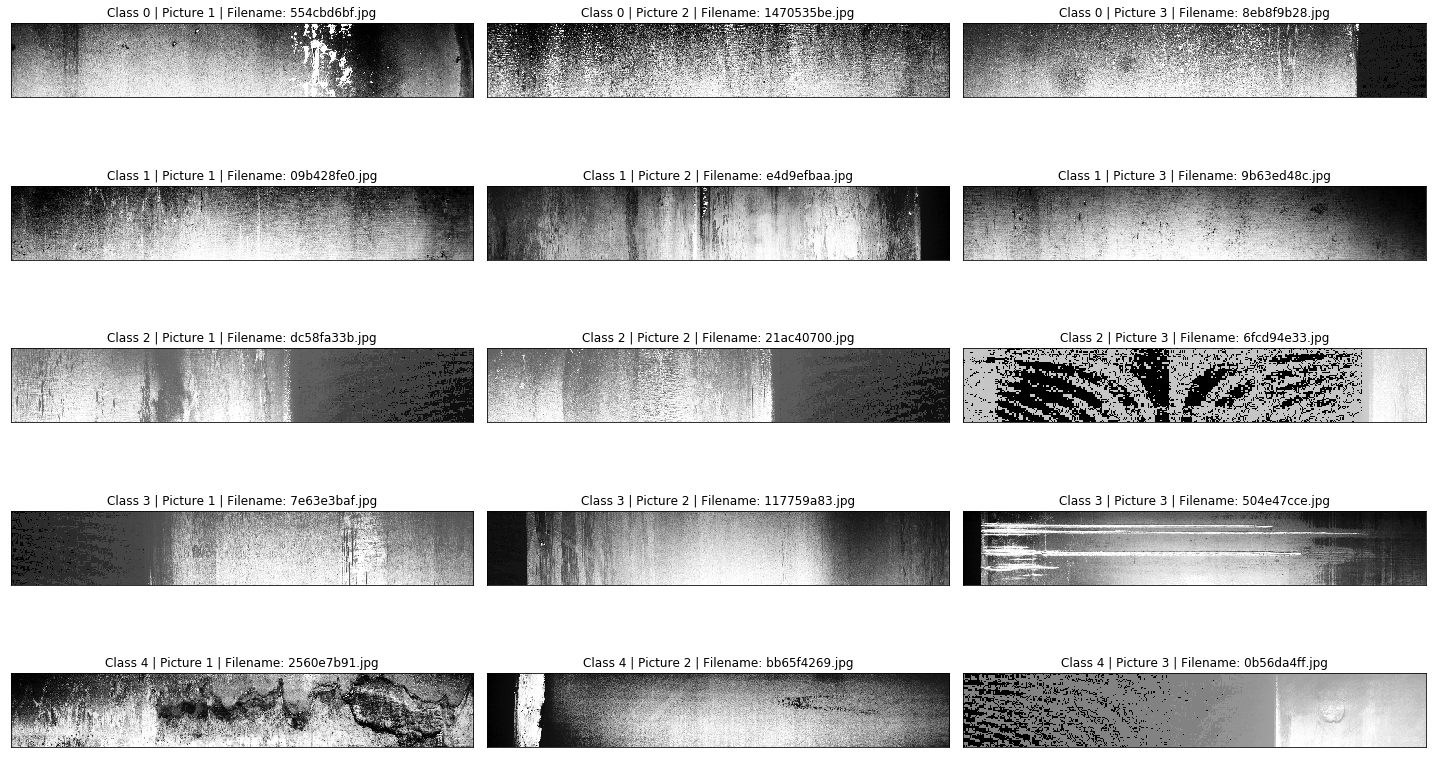

In [ ]:
#Plot the same images from above without masks, but this time with histogram equalization
fig, axs = plt.subplots(numClasses, numImagesPerClass, figsize=(numClasses*4,numImagesPerClass*4))
filenameIter = iter(pltFilenames)
for i in range(numClasses):
    for j in range(numImagesPerClass): 
        #Plot the image with a defect mask applied
        filename = next(filenameIter)
        img = imgHistogramEqualization(RGBToGrey(imageToRGBArray(getImage(filename))))[0]
        axs[i, j].imshow(img, cmap = "gray")
        axs[i, j].set_title("Class " + str(i) + " | Picture " + str(j+1) + " | Filename: " + str(filename))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()

3.2.4 - Example images processed with thresholding

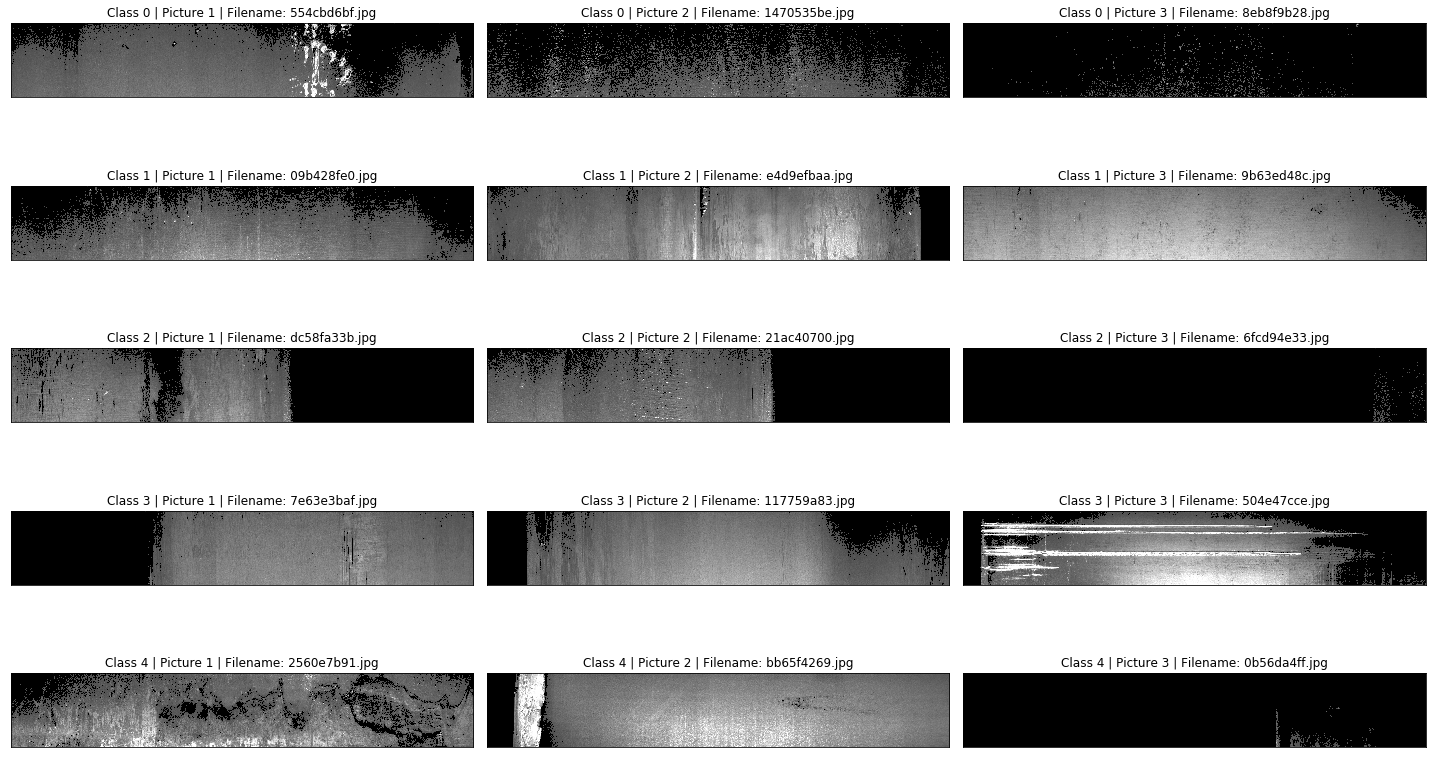

In [ ]:
#Plot the same images from above without masks, but this time with thresholding
fig, axs = plt.subplots(numClasses, numImagesPerClass, figsize=(numClasses*4,numImagesPerClass*4))
filenameIter = iter(pltFilenames)
for i in range(numClasses):
    for j in range(numImagesPerClass): 
        #Plot the image with a defect mask applied
        filename = next(filenameIter)
        img = thresholdImg(imageToRGBArray(getImage(filename)), 0.3)
        axs[i, j].imshow(img)
        axs[i, j].set_title("Class " + str(i) + " | Picture " + str(j+1) + " | Filename: " + str(filename))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()

3.2.5 - Example images processed with Sobel filters (horizontal/vertical edge detection)

refer to http://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf for more information on this filter

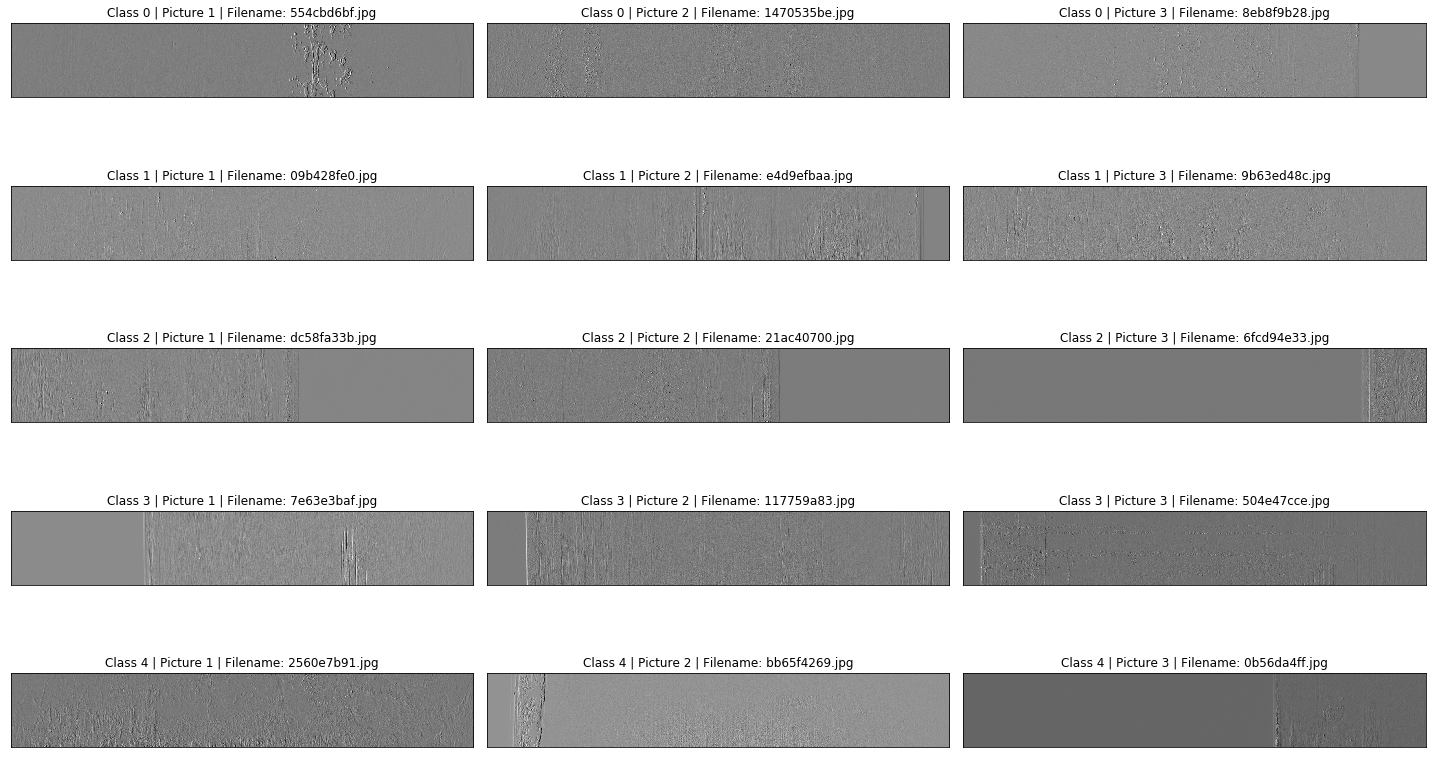

In [ ]:
#Plot the same images from above without masks, but this time with a Sobel filter
fig, axs = plt.subplots(numClasses, numImagesPerClass, figsize=(numClasses*4,numImagesPerClass*4))
filenameIter = iter(pltFilenames)
for i in range(numClasses):
    for j in range(numImagesPerClass): 
        filename = next(filenameIter)
        img = sobelImg(RGBToGrey(imageToRGBArray(getImage(filename))))
        axs[i, j].imshow(img, cmap = "gray")
        axs[i, j].set_title("Class " + str(i) + " | Picture " + str(j+1) + " | Filename: " + str(filename))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()

3.2.6 - Example images processed with a Laplacian derivative filter and gaussian smoothing

refer to http://www.cs.cmu.edu/~16385/s17/Slides/4.0_Image_Gradients_and_Gradient_Filtering.pdf for more information on this filter

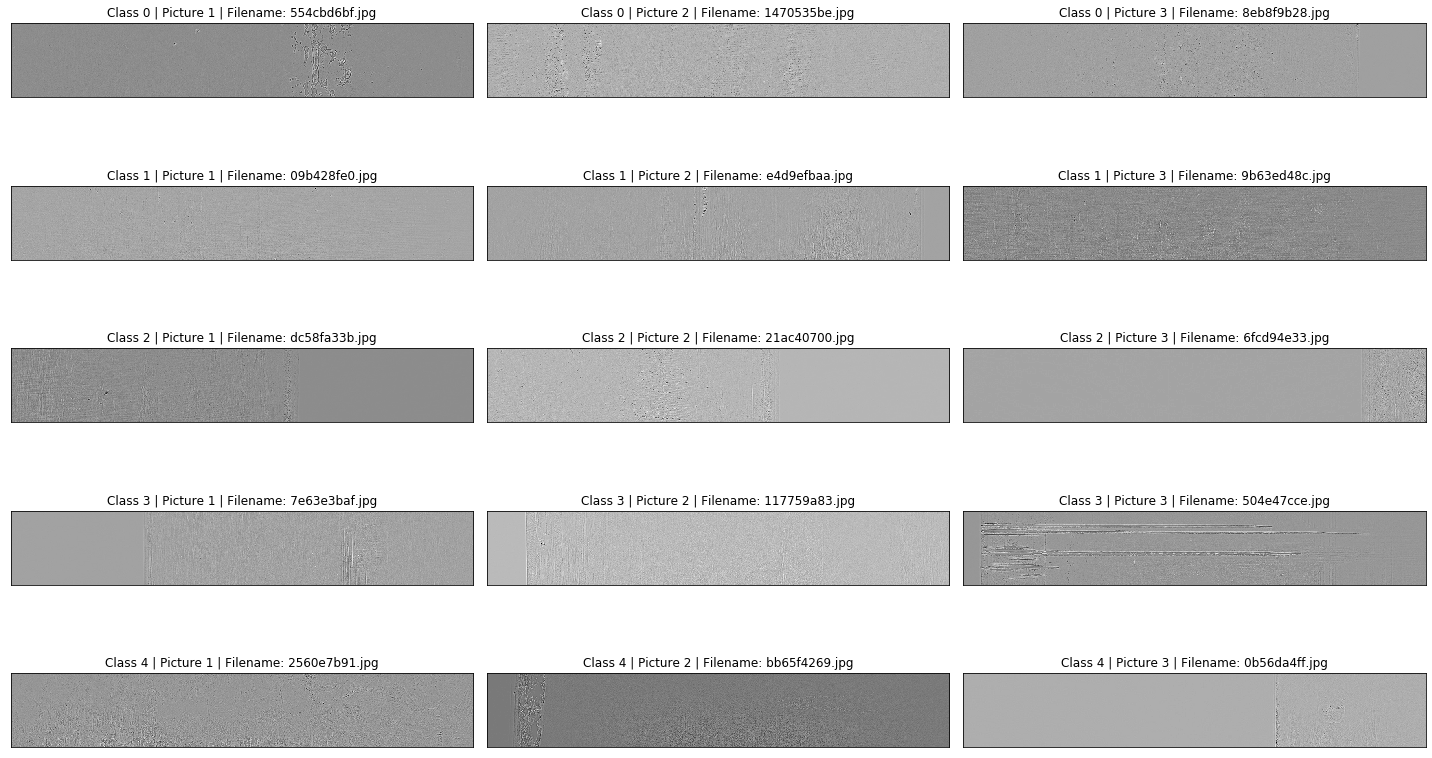

In [ ]:
#Plot the same images from above without masks, but this time with a Laplace filter with gaussian smoothing
fig, axs = plt.subplots(numClasses, numImagesPerClass, figsize=(numClasses*4,numImagesPerClass*4))
filenameIter = iter(pltFilenames)
for i in range(numClasses):
    for j in range(numImagesPerClass): 
        filename = next(filenameIter)
        img = gaussianLaplaceImg(RGBToGrey(imageToRGBArray(getImage(filename))))
        axs[i, j].imshow(img, cmap = "gray")
        axs[i, j].set_title("Class " + str(i) + " | Picture " + str(j+1) + " | Filename: " + str(filename))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
fig.tight_layout()

**Conclusions:**

*From pie chart*
- Of the images with defects, class 3 is the most common, followed by classes 1, 4, and 2
- A majority of the images have no defects

*From comparison matrix*
- The most common combination of multi-class defects in an image is a combination of class 3 and class 4. This is followed by class 1 and class 3, class 1 and class 2, class 2 and class 3, and class 2 and class 4.

*From pixel intensity histogram*
- Class 2 defects are generally distributed over lower intensities than any other class
- Classes 1 and 3 have similar distributions, meaning it may potentially be difficult to distinguish between them
- Class 0's peak on the histogram is at a higher intensity than the peak for any other class, potentially meaning that images without defects will have a majority of their pixels at intensities higher than for any other class
- Class 4 pictures do not seem to peak at a certain intensity; the pixels have a relatively equal distribution of intensities. Additionally, the right side of class 4’s distribution does not overlap with any other class, meaning that any images with relatively bright/white pixels are more likely to be in an image belonging to class 4  


*From visualizing defect images*
- Class 1 defects seem to be tiny transverse cracks/indentations or potentially pitting due to their relatively small size compared to the other defect classes(i.e. crack length extends into the page, but is being viewed from above)
- Class 2 defects seem the most difficult to detect, they are barely noticeable vertical scratches on the surface. This class may be difficult to detect due to this observation, as well as the fact that the dataset has the least amount of images in this class
- Class 3 defects seem to be scratches/indentations, typically vertical, going a shallow depth into the steel
- Class 4 defects look like larger and deeper indentations/pits as compared to class 3


*From trying potential pre-proccessing filters*

Histogram equalization
- Highlighted contrast around defects in classes 3 and 4 (which are typically larger than the other classes defects)
- Didn’t work well for class 2 or class 1 where the defects are smaller in size
- Generally doesn't work well for any image where there is a lot of black space and the steel does not cover the whole image. 
> - Lesson learned:  images should be pre-processed to check for empty black space and then have it removed.
CNN would be able to handle inputs of different sizes, but padding would need to be added around the output so all images have consistent sizing when going through any linear layers.
>> - CNN would be able to handle inputs of different sizes, but padding would need to be added around the output so all images have consistent sizing when going through any linear layers.

Thresholding
- Generally unhelpful
- Identified some contrast around the class 4 defects, but not as well as histogram equalization
- Thresholds need to be low if used since the images are fairly dark

Sobel
- Worked ok with classes 1-3 where defects were typically small or vertical
- Seemed to “grey” everything, but then have a “texture”/”contrast” around the defects

Laplacian (with Gaussian smoothing)
- Similar to Sobel results but even “smoother” because it is a derivative of Sobel
- Greyed everything, but around most defects became more white with some tiny black specs

Based on the discussion above, Histogram equalization, Sobel, and Laplacian can all potentially be used at random on some images in the training set to increase the model’s robustness. 

# **4. Split Filenames For Training, Validation and Testing Sets**

In [ ]:
#Split into training, validation, and testing set

#First split up the filenames randomly. Use a 70-15-15 split within each class, append to the set, and then remove duplicates
def splitFilenames(useClass0 = False):
    if useClass0:
        x = 0
    else:
        x = 1
    
    trainImageNames, valImageNames, testImageNames = [], [], []
    for i in range(x, numClasses): #1, numClasses if ignoring classes without defects
        filesForClass = filenamesByClass[i]
        random.seed(1)
        random.shuffle(filesForClass)

        trainImageNames.append(filesForClass[:int(0.7*len(filesForClass))])
        valImageNames.append(filesForClass[int(0.7*len(filesForClass)):int(0.85*len(filesForClass))])
        testImageNames.append(filesForClass[int(0.85*len(filesForClass)):len(filesForClass)])

    #Flatten 2D lists to 1D
    trainImageNames = list(itertools.chain(*trainImageNames))
    valImageNames = list(itertools.chain(*valImageNames))
    testImageNames = list(itertools.chain(*testImageNames))

    #Remove duplicate names
    trainImageNames = removeDuplicates(trainImageNames)
    valImageNames = removeDuplicates(valImageNames)
    testImageNames = removeDuplicates(testImageNames)

    #Shuffle again to mix up the classes
    random.shuffle(trainImageNames)
    random.shuffle(valImageNames)
    random.shuffle(testImageNames)

    return (trainImageNames, valImageNames, testImageNames)

trainImageNames, valImageNames, testImageNames = splitFilenames()
trainImageNames0, valImageNames0, testImageNames0 = splitFilenames(useClass0 = True)

# **5. Load Images and Segmentation Masks**

In [ ]:
#Functions to convert encodedPixels string into a segmentation mask and vice versa
def rle_decode(encodedPixels, picWidth, picHeight): 
    '''
    Input: run length as string formated, width, height
    Returns: numpy array, 1 - mask, 0 - background
    '''
    numPixels = picWidth * picHeight
    mask = np.zeros((picHeight, picWidth))
    if encodedPixels == "":
        return mask
    
    encodedPixelsList = encodedPixels.split()
    for j in range(0, len(encodedPixelsList), 2): #iterate over locations within encodedPixels (every other value)
        for k in range(1, int(encodedPixelsList[j+1]) + 1): #create range of the size that is the number of pixels to paint
            pixelNum = int(encodedPixelsList[j]) + k - 1
            xPos = math.floor(pixelNum / picHeight)
            if pixelNum == picWidth * picHeight:
                xPos = xPos - 1
            #yPos = pixelNum % picHeight
            yPos = pixelNum - picHeight*xPos - 1
            mask[yPos, xPos] = 1
    return mask

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten('F')
    non_zero_indices = np.nonzero(pixels)[0]
    rle = []
    #Count numbers beside each other that are one more than the previous, remove them from non_zero_indices, 
    #then repeat until nothing is left of non_zero_indices and the full rle string is written
    while np.size(non_zero_indices) > 1:
        index = 0

        while non_zero_indices[index + 1] - non_zero_indices[index] == 1:
            index += 1
            if index >= np.size(non_zero_indices) - 1:
                break
        index += 1
        
        rle.append(non_zero_indices[0])
        rle.append(index)
        non_zero_indices = non_zero_indices[index:]
    return ' '.join(str(num) for num in rle)

In [ ]:
#Custom dataset class to load the images, segmentation masks, and apply consistent transformations to them
default_resize_width = int(1600/2) #also try 88x550 or 92x575. Same order of magnitude as Alexnet 224^2
default_resize_height = int(256/2)

class SteelImageDataset(Dataset):
    """Steel image dataset."""

    def __init__(self, filenames_list, rle_data, resize_width = int(1600/2), resize_height = int(256/2), apply_transforms = True, transform_apply_prob = 0.25, max_angle = 4):
        """
        Args:
            filenames_list (list): list of filenames for the class.
            rle_data (list): original train.csv file loaded as a 2D list
        """
        self.filenames_list = filenames_list
        self.rle_data = rle_data
        self.resize_width = resize_width
        self.resize_height = resize_height
        self.apply_transforms = apply_transforms #choose whether flips and rotations are done
        self.transform_apply_prob = transform_apply_prob
        self.max_angle = max_angle

    def __len__(self):
        return len(self.filenames_list)

    def transform(self, image, masks):
        new_masks, mask_tensors, temp = [], [], []
        
        # Resize
        image = cv2.resize(image, (self.resize_width, self.resize_height))
        for mask in masks:
            temp.append(cv2.resize(mask, (self.resize_width, self.resize_height)))
        new_masks = np.array(temp)
        temp = []
        
        if self.apply_transforms:
            # Random horizontal flipping with a probability of occuring 25% of the time
            if np.random.random() < self.transform_apply_prob:
                image = np.flip(image, 1)
                for mask in new_masks:
                    temp.append(np.flip(mask, 1))
                new_masks = np.array(temp)
                temp = []
            
            # Random vertical flipping with a probability of occuring 25% of the time
            if np.random.random() < self.transform_apply_prob:
                image = np.flip(image, 0)
                for mask in new_masks:
                    temp.append(np.flip(mask, 0))
                new_masks = np.array(temp)
                temp = []
        
            # Random rotations with a probability of occuring 25% of the time
            if np.random.random() < self.transform_apply_prob:
                angle = random.uniform(0, self.max_angle)
                image = ndimage.rotate(image, angle, reshape = False)
                for mask in new_masks:
                    temp.append(ndimage.rotate(mask, angle, reshape = False))
                new_masks = np.array(temp)
                temp = []
        
        # Transform to tensor
        image = torch.from_numpy(image.copy())
        mask_tensors = torch.from_numpy(new_masks.copy())
    
        return image, mask_tensors

    def __getitem__(self, idx):
        filename = self.filenames_list[idx]
        img_name = "/content/train_images/" + filename
        image = imageToRGBArray(getImage(img_name)) #Resnet needs a 3 channel img, so don't convert to RGB
        #image = RGBToGrey(imageToRGBArray(getImage(img_name)))
        masks, transformedMasks = [], []

        for i in range(1, numClasses):       
            masks.append(rle_decode(getEncodedPixels(self.filenames_list[idx], i), image.shape[1], image.shape[0]))
        masks = np.asarray(masks)

        image_tensor, transformedMasks = self.transform(image, masks)
        image_tensor = image_tensor.permute(2, 0, 1)

        return image_tensor, transformedMasks, filename

In [ ]:
train_dataset = SteelImageDataset(trainImageNames, data, resize_width = 576, resize_height = 96)
val_dataset = SteelImageDataset(valImageNames, data, resize_width = 576, resize_height = 96)
test_dataset = SteelImageDataset(testImageNames, data, resize_width = 576, resize_height = 96, transform_apply_prob = 0)

train_dataset0 = SteelImageDataset(trainImageNames0, data, resize_width = 576, resize_height = 96)
val_dataset0 = SteelImageDataset(valImageNames0, data, resize_width = 576, resize_height = 96)
test_dataset0 = SteelImageDataset(testImageNames0, data, resize_width = 576, resize_height = 96, transform_apply_prob = 0)

print("There are", len(train_dataset), "images in the training set")
print("There are", len(val_dataset), "images in the validation set")
print("There are", len(test_dataset), "images in the testing set")

There are 4760 images in the training set
There are 1055 images in the validation set
There are 1055 images in the testing set


torch.Size([3, 96, 576])


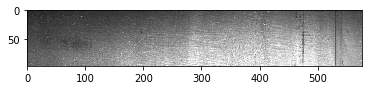

In [ ]:
# a known image with defects in class 3
image, masks, _ = train_dataset[0] 
print(image.shape)
image = image.permute(1, 2, 0)
plt.imshow(image.numpy(), cmap = 'gray')

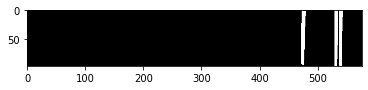

In [ ]:
#verify that class 3 map is transformed correctly
plt.imshow(masks.numpy()[2], cmap = 'gray') 

# **6. Model Architecture**

In [ ]:
#U-Net Architecture (to use for final model) (from https://github.com/usuyama/pytorch-unet)

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.name = "ResNetUNet"
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

# **7. Training Functions**

In [ ]:
def dice_loss(pred, target, smooth = 1E-9):
    # taken from https://github.com/usuyama/pytorch-unet
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, bce_weight=0.25):
    # taken from https://github.com/usuyama/pytorch-unet
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

def dice_channel_batch(probability, truth, threshold):
    # taken from https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_dice_channel = 0.
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_dice = dice_single_channel(probability[i, j,:,:], truth[i, j, :, :], threshold)
                #print("Channel", j, " - Dice:", channel_dice)
                mean_dice_channel += channel_dice/(batch_size * channel_num)
    return mean_dice_channel

def dice_single_channel(probability, truth, threshold, eps = 1E-9):
    # taken from https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition
    #print(probability)
    p = (probability.view(-1) > threshold).float()
    t = (truth.view(-1) > 0.5).float()
    #print(p)
    dice = (2.0 * (p * t).sum() + eps)/ (p.sum() + t.sum() + eps)
    #print("Channel Dice", dice)
    return dice

def get_accuracy(model, dataset, batch_size, useGPU = True, useAllDataForAccuracy = False):
    #To save time, only evaluate accuracy for 2.5% of the total number of batches at random if useAllDataForAccuracy == False 
    
    #start = time.time()

    if useAllDataForAccuracy == False:
        shuffle = True
    else: 
        shuffle = False

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                    num_workers=0, shuffle=shuffle)

    all_batch_dice = []
    for i, batch in enumerate(data_loader):       
        imgs, masks, _ = batch
        imgs = imgs.float()
        
        #To Enable GPU Usage
        if useGPU and torch.cuda.is_available():
            imgs = imgs.cuda()
            masks = masks.cuda()
            model = model.cuda()

        model = model.eval()
        output = model(imgs)

        batch_dice = dice_channel_batch(output, masks, 0.2).detach().cpu().numpy()
        #print("Batch Dice:", batch_dice)
        all_batch_dice.append(float(batch_dice))

        if useAllDataForAccuracy == False and i >= int(0.025*len(data_loader)):
            break
    #print("Time in get_accuracy:", time.time() - start)
    return(np.mean(np.asarray(all_batch_dice)))

def plot_training_curve(iters, losses, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    print("Maximum Training Accuracy: {0}. Epoch: {1}".format(max(train_acc), np.argmax(train_acc)))
    print("Maximum Validation Accuracy: {0}. Epoch {1}".format(max(val_acc), np.argmax(val_acc)))  

def train(model, train_dataset, val_dataset, batch_size=64, num_epochs=1, learning_rate = 0.01, momentum = 0.9, 
          useGPU = True, saveWeights = True, printIterations = False, useAdams = True, useAllDataForAccuracy = False, useDiceLoss = False):
    
    #Put data in data loaders
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            num_workers=0, shuffle=False)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                        num_workers=0, shuffle=False)
    
    criterion = nn.BCEWithLogitsLoss()
    
    if useAdams:
        optimizer = optim.Adam(model.parameters(), learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    
    iters, losses, train_acc, val_acc = [], [], [], []

    if useGPU and torch.cuda.is_available():
        model = model.cuda()
        print("Training on GPU")
   
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_data_loader):
            imgs, masks, _ = batch
            imgs = imgs.float()
            
            #To Enable GPU Usage
            if useGPU and torch.cuda.is_available():
                imgs = imgs.cuda()
                masks = masks.cuda()

            model = model.train()
            out = model(imgs)             # forward pass

            
            if useDiceLoss:
                loss = calc_loss(out, masks)
            else:
                loss = criterion(out, masks) # compute the total loss

            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            
            
            train_acc.append(get_accuracy(model, train_dataset, batch_size, useGPU, useAllDataForAccuracy)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_dataset, batch_size, useGPU, useAllDataForAccuracy))  # compute validation accuracy
            if printIterations:
                print("Iteration: ", str(n), "| Train Loss: ", losses[n], "| Train Accuracy: ", train_acc[n], "| Validation Accuracy: ", val_acc[n])
            
            n += 1
            
        # Save the current model (checkpoint) to a file
            if saveWeights:
                model_path = "model_{0}_bs{1}_lr{2}_epoch{3}_iteration{4}".format(model.name,
                                                       batch_size,
                                                       str(learning_rate).replace('.', '-'),
                                                       epoch, n)
            #Save the weights if the validation accuracy is a new maximum
                if val_acc[-1] == max(val_acc):
                    torch.save(model.state_dict(), model_path + ".pth")           

    #Save the very last epoch's weights
    if saveWeights:
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                            batch_size,
                                            str(learning_rate).replace('.', '-'),
                                            epoch)
        torch.save(model.state_dict(), model_path + ".pth")
    
    # Write the train/test loss/err into CSV file for plotting later
    if saveWeights:
        epochs = np.arange(1, num_epochs + 1)
        np.savetxt("{}_train_loss.csv".format(model_path), losses)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)            

    # plotting
    plot_training_curve(iters, losses, train_acc, val_acc)

# **8. Verify Models Overfitting Small Datasets**

**8.1 - Dataset of only one image**

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.7MB/s]


Training on GPU
Iteration:  0 | Train Loss:  0.054804941179228676 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  1 | Train Loss:  0.9619990237200331 | Train Accuracy:  0.7636685967445374 | Validation Accuracy:  0.7623345255851746
Iteration:  2 | Train Loss:  0.6535788772507217 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  3 | Train Loss:  0.050835493287531085 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  4 | Train Loss:  0.0879411258929823 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  5 | Train Loss:  0.10181514661418663 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  6 | Train Loss:  0.10159039812241179 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  7 | Train Loss:  0.08880767962815746 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  8 | Train Loss:  0.07881997619886212 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  9 | Train Loss:  0.06291475

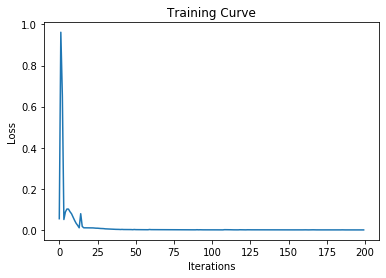

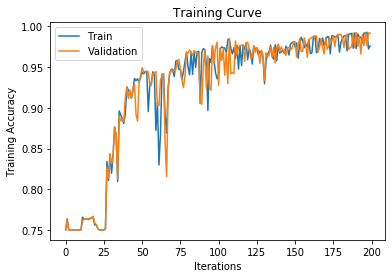

Final Training Accuracy: 0.9759591221809387
Final Validation Accuracy: 0.9916413426399231
Maximum Training Accuracy: 0.9929358959197998. Epoch: 197
Maximum Validation Accuracy: 0.9924242496490479. Epoch 190


In [ ]:
#Verify overfitting on a single image known a priori to have class 3 defects
one_image_overfit_model = ResNetUNet(4)

one_image_overfit_set = SteelImageDataset([trainImageNames[0]], data)

train(one_image_overfit_model, one_image_overfit_set, one_image_overfit_set, batch_size = 6, num_epochs = 200, 
      learning_rate = 0.003, momentum = 0.9, printIterations = True, saveWeights=False, useAllDataForAccuracy = True)

Image: eef10580b.jpg


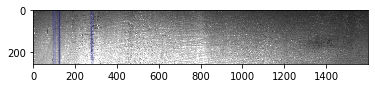

In [ ]:
#View the image with ground-truth masks

colours = [(255, 0, 0, 30), (0, 255, 0, 30), (0, 0, 255, 30), (255, 255, 0, 30)] #red, green, blue, yellow, @ 30% opacity
print("Image:", trainImageNames[0])
one_image = getImage(trainImageNames[0])
for i in range(1, numClasses):
    one_image = applyMask(one_image, getEncodedPixels(trainImageNames[0], i), colours[i-1])

plt.imshow(imageToRGBArray(one_image))
saveImage(one_image, "1 image overfit ground truth")

In [ ]:
#Copy the checkpoint file to directory /content/
checkpoint_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}.pth".format("ResNetUNet", "6", "0-005", "295")
shutil.copy("/content/drive/My Drive/2019 Fall/APS360/Project/APS360 2019 September Team/Steel Defect Detection/" + checkpoint_model_path,"/content/" + checkpoint_model_path)

# Load the checkpoint weights into the model
model = ResNetUNet(4)
state = torch.load(checkpoint_model_path)
model.load_state_dict(state)
model = model.eval()

In [ ]:
def predictionFromModel(model, img_filepath_and_name):
    one_image = getImage(img_filepath_and_name)
    imgs = torch.unsqueeze(torch.from_numpy(imageToRGBArray(one_image)), 0)
    imgs = imgs.permute(0, 3, 1, 2)
    imgs = imgs.float()
    imgs = imgs.cuda()

    #scale the image down to how the model was trained
    imgs = F.interpolate(imgs, size=(default_resize_height,default_resize_width), mode='bilinear', align_corners=False)

    #Make a prediction
    model = model.cuda()
    out = model(imgs)

    out_resized = F.interpolate(out, size=(int(list(imgs.shape())[2]),int(list(imgs.shape())[3])), mode='bilinear', align_corners=False) # bring output back up to original size.

    out_resized[out_resized <= 0] = 0
    out_resized[out_resized > 0] = 1

    out_resized = out_resized.cpu().detach().numpy()[0]

    colours = [(255, 0, 0, 30), (0, 255, 0, 30), (0, 0, 255, 30), (255, 255, 0, 30)] #red, green, blue, yellow, @ 30% opacity
    rles = []
    for i in range(1, numClasses):
        rles.append(rle_encode(out_resized[i-1]))
        one_image = applyMask(one_image, rle_encode(out_resized[i-1]), colours[i-1])

    return (one_image, imageToRGBArray(one_image), rles) #Can choose which to keep when calling the function

Predicted defects for eef10580b.jpg


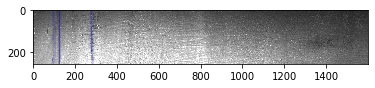

In [ ]:
#View the image with predicted masks

#Get the image to pass to the model
one_image = getImage(trainImageNames[0])
imgs = torch.unsqueeze(torch.from_numpy(imageToRGBArray(one_image)), 0)
imgs = imgs.permute(0, 3, 1, 2)
imgs = imgs.float()
imgs = imgs.cuda()

#scale the image down to how the model was trained
imgs = F.interpolate(imgs, size=(default_resize_height,default_resize_width), mode='bilinear', align_corners=False)

#Make a prediction
model = model.cuda()
out = model(imgs)

out_resized = F.interpolate(out, size=(256,1600), mode='bilinear', align_corners=False) # bring output back up to original size. Note: dont hardcode image size, get from input image.shape

out_resized[out_resized <= 0] = 0
out_resized[out_resized > 0] = 1

out_resized = out_resized.cpu().detach().numpy()[0]

for i in range(1, numClasses):
    one_image = applyMask(one_image, rle_encode(out_resized[i-1]), colours[i-1])

print("Predicted defects for", trainImageNames[0])
plt.imshow(imageToRGBArray(one_image))
saveImage(one_image, "1 image overfit predicted")


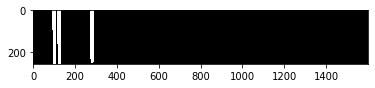

In [ ]:
#Class 3 ground-truth mask
plt.imshow(rle_decode(getEncodedPixels(trainImageNames[0],3), 1600, 256), cmap = 'gray')

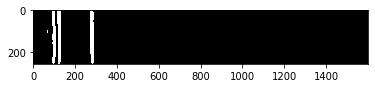

In [ ]:
plt.imshow(out_resized[2], cmap = 'gray')

**8.2 - Dataset of 35 images**

Training on GPU
Iteration:  0 | Train Loss:  0.35616910070145275 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  1 | Train Loss:  0.6521392038320117 | Train Accuracy:  0.7685262560844421 | Validation Accuracy:  0.7662531137466431
Iteration:  2 | Train Loss:  0.03039189983297017 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  3 | Train Loss:  0.05240733511942174 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  4 | Train Loss:  0.04297772702108719 | Train Accuracy:  0.7814542055130005 | Validation Accuracy:  0.7733362913131714
Iteration:  5 | Train Loss:  0.013161963062989718 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  6 | Train Loss:  0.04437485982230834 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  7 | Train Loss:  0.060827352102103514 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration:  8 | Train Loss:  0.05498120807135093 | Train Accuracy:  0.75 | Validation Accuracy:  0.75
Iteration

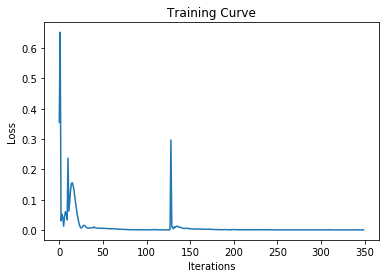

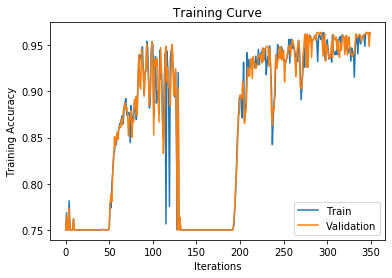

Final Training Accuracy: 0.9636856317520142
Final Validation Accuracy: 0.9636856317520142
Maximum Training Accuracy: 0.963860034942627. Epoch: 345
Maximum Validation Accuracy: 0.9641193151473999. Epoch 293


In [ ]:
#Verify overfitting on a set of 35 images
overfit_model = ResNetUNet(4)

overfit_set = SteelImageDataset([trainImageNames[0]], data)

train(overfit_model, overfit_set, overfit_set, batch_size = 6, num_epochs = 350, 
      learning_rate = 0.003, momentum = 0.9, printIterations = True, saveWeights=False, useAllDataForAccuracy = True)

# **9. Train U-Net Model**

In [ ]:
model = ResNetUNet(4)

train(model, train_dataset, val_dataset, batch_size = 40, num_epochs = 85, 
      learning_rate = 0.003, momentum = 0.9, printIterations = True, saveWeights=True, useAllDataForAccuracy = False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Training on GPU
Iteration:  0 | Train Loss:  0.011025901822617507 | Train Accuracy:  0.7333338658014933 | Validation Accuracy:  0.7375005483627319
Iteration:  1 | Train Loss:  0.24873924150073012 | Train Accuracy:  0.6965991457303365 | Validation Accuracy:  0.6456500291824341
Iteration:  2 | Train Loss:  0.046256632584804176 | Train Accuracy:  0.7145837942759196 | Validation Accuracy:  0.6812503337860107
Iteration:  3 | Train Loss:  0.011509082440482172 | Train Accuracy:  0.7125004529953003 | Validation Accuracy:  0.6875003576278687
Iteration:  4 | Train Loss:  0.015676433734384418 | Train Accuracy:  0.7145837942759196 | Validation Accuracy:  0.7062504291534424
Iteration:  5 | Train Loss:  0.015930344367782245 | Train Accuracy:  0.6854170163472494 | Validation Accuracy:  0.6937503814697266
Iteration:  6 | Train Loss:  0.013851600898352967 | Train Accuracy:  0.7020837465922037 | Validation Accuracy:  0.6875003576278687
Iteration:  7 | Train Loss:  0.010851950632767154 | Train Accuracy: 

In [ ]:
#Continue training from the last checkpoint
#Copy the checkpoint file to directory /content/
checkpoint_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}_iteration{4}.pth".format("ResNetUNet", "40", "0-003", "15", "1805")
shutil.copy("/content/drive/My Drive/2019 Fall/APS360/Project/APS360 2019 September Team/Steel Defect Detection/96 x 576 weights/" + checkpoint_model_path,"/content/" + checkpoint_model_path)


NameError: ignored

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.7MB/s]


Training on GPU
Iteration:  0 | Train Loss:  0.0005760876042453474 | Train Accuracy:  0.7840494314829508 | Validation Accuracy:  0.7730967402458191
Iteration:  1 | Train Loss:  0.001067224607498443 | Train Accuracy:  0.780519704023997 | Validation Accuracy:  0.7717604637145996
Iteration:  2 | Train Loss:  0.0009569103157756555 | Train Accuracy:  0.7075602412223816 | Validation Accuracy:  0.6948164701461792
Iteration:  3 | Train Loss:  0.0009342808313199688 | Train Accuracy:  0.7328142325083414 | Validation Accuracy:  0.7085251212120056
Iteration:  4 | Train Loss:  0.0009479853966673439 | Train Accuracy:  0.7604219913482666 | Validation Accuracy:  0.7230954766273499
Iteration:  5 | Train Loss:  0.0009593791215770848 | Train Accuracy:  0.732023298740387 | Validation Accuracy:  0.7295448184013367
Iteration:  6 | Train Loss:  0.0007842503767970483 | Train Accuracy:  0.7661085526148478 | Validation Accuracy:  0.7521252036094666
Iteration:  7 | Train Loss:  0.0009696275401243442 | Train Accu

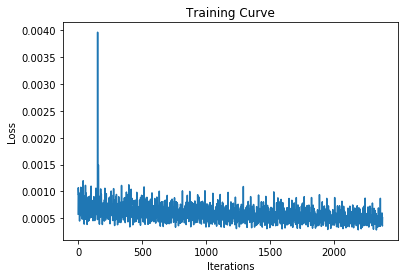

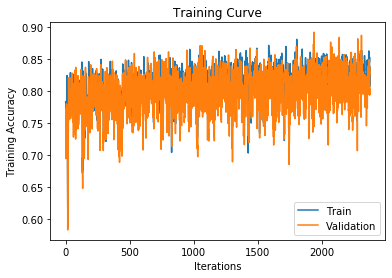

Final Training Accuracy: 0.8377702633539835
Final Validation Accuracy: 0.8377191424369812
Maximum Training Accuracy: 0.8814908464749655. Epoch: 1806
Maximum Validation Accuracy: 0.8925483226776123. Epoch 1942


In [ ]:
# Load the checkpoint weights into the model
model = ResNetUNet(4)
state = torch.load(checkpoint_model_path)
model.load_state_dict(state)

train(model, train_dataset, val_dataset, batch_size = 40, num_epochs = 20, 
      learning_rate = 0.002, momentum = 0.9, printIterations = True, saveWeights=True, useAllDataForAccuracy = False, useDiceLoss = False)

# **10. Results**

In [ ]:
def predictionFromModel(model, img_filepath_and_name, scale_down_height = 96, scale_down_width = 576, paint_opacity = 45, getMeanDice = False):
    one_image = getImage(img_filepath_and_name)
    imgs = torch.unsqueeze(torch.from_numpy(imageToRGBArray(one_image)), 0)
    imgs = imgs.permute(0, 3, 1, 2)
    imgs = imgs.float()
    imgs = imgs.cuda()

    #scale the image down to how the model was trained
    #imgs = F.interpolate(imgs, size=(scale_down_height,scale_down_width), mode='bilinear', align_corners=False)

    #Make a prediction
    model = model.cuda()
    out = model(imgs)

    height = int(list(imgs.shape)[2])
    width = int(list(imgs.shape)[3])
    out_resized = F.interpolate(out, size=(height,width), mode='bilinear', align_corners=False) # bring output back up to original size.

    out_resized[out_resized <= 0] = 0
    out_resized[out_resized > 0] = 1

    if getMeanDice:
        dice = get_accuracy(model, SteelImageDataset([img_filepath_and_name.split('/')[-1]], data, 1600, 256,False), 1, useGPU = True, useAllDataForAccuracy = True)

    out_resized = out_resized.cpu().detach().numpy()[0]

    colours = [(255, 0, 0, paint_opacity), (0, 255, 0, paint_opacity), (0, 0, 255, paint_opacity), (255, 255, 0, paint_opacity)] #red, green, blue, yellow
    rles = []
    for i in range(1, numClasses):
        rles.append(rle_encode(out_resized[i-1]))
        one_image = applyMask(one_image, rle_encode(out_resized[i-1]), colours[i-1])

    if getMeanDice:
        return (one_image, imageToRGBArray(one_image), rles, dice)
    else:
        return (one_image, imageToRGBArray(one_image), rles) #Can choose which to keep when calling the function

In [ ]:
#Load the best model
#Download the model (link: https://drive.google.com/file/d/1PRnCLKHfpprMrBlHcmpucDSQF2_rvE_5/view?usp=sharing) and re-upload it here. Do not change the file's name
files.upload()
checkpoint_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}_iteration{4}.pth".format("ResNetUNet", "40", "0-002", "16", "1943")

In [ ]:
#Load the best model (this will only work for Farhan; use block above otherwise)

checkpoint_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}_iteration{4}.pth".format("ResNetUNet", "40", "0-002", "16", "1943")
shutil.copy("/content/drive/My Drive/2019 Fall/APS360/Project/APS360 2019 September Team/Steel Defect Detection/96 x 576 weights/" + checkpoint_model_path,"/content/" + checkpoint_model_path)


'/content/model_ResNetUNet_bs40_lr0-002_epoch16_iteration1943.pth'

In [ ]:
# Load the checkpoint weights into the model
model = ResNetUNet(4)
state = torch.load(checkpoint_model_path)
model.load_state_dict(state)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 288MB/s]


<All keys matched successfully>

In [ ]:
# Get final accuracies for the chosen best model. Note: these sets do NOT include class 0
train_acc = get_accuracy(model, train_dataset, 10, useGPU = True, useAllDataForAccuracy = True)
val_acc = get_accuracy(model, val_dataset, 10, useGPU = True, useAllDataForAccuracy = True)
test_acc = get_accuracy(model, test_dataset, 10, useGPU = True, useAllDataForAccuracy = True)

print("The accuracy on the training set is", train_acc)
print("The accuracy on the validation set is", val_acc)
print("The accuracy on the test set is", test_acc)

The accuracy on the training set is 0.841961299045747
The accuracy on the validation set is 0.8223973552011093
The accuracy on the test set is 0.8319860629315646


In [ ]:
# Get final accuracies for the chosen best model. Note: these sets do include class 0
train_acc0 = get_accuracy(model, train_dataset0, 10, useGPU = True, useAllDataForAccuracy = True)
val_acc0 = get_accuracy(model, val_dataset0, 10, useGPU = True, useAllDataForAccuracy = True)
test_acc0 = get_accuracy(model, test_dataset0, 10, useGPU = True, useAllDataForAccuracy = True)

print("The accuracy on the training set is", train_acc)
print("The accuracy on the validation set is", val_acc)
print("The accuracy on the test set is", test_acc)

The accuracy on the training set is 0.8403137501548318
The accuracy on the validation set is 0.8199112842667777
The accuracy on the test set is 0.8319860629315646


In [ ]:
#Save images of predictions on the validation set
os.makedirs("/content/val_images_highlighted_predicted/")
for imgName in valImageNames:
    img_file, _, _ = predictionFromModel(model, "/content/train_images/" + imgName)
    os.chdir("/content/val_images_highlighted_predicted/")
    img_file.save("Highlighted_Predicted " + imgName)

#zip the files
os.chdir("/content/")
shutil.make_archive("val_images_highlighted_predicted", 'zip', "/content/val_images_highlighted_predicted")

In [ ]:
#Save images of predictions on the testing set
os.makedirs("/content/test_images_highlighted_predicted/")
for imgName in testImageNames:
    img_file, _, _ = predictionFromModel(model, "/content/train_images/" + imgName)
    os.chdir("/content/test_images_highlighted_predicted/")
    img_file.save("Highlighted_Predicted " + imgName)

#zip the files
os.chdir("/content/")
shutil.make_archive("test_images_highlighted_predicted", 'zip', "/content/test_images_highlighted_predicted")

'/content/test_images_highlighted_predicted.zip'

In [ ]:
#Get dice coefficient for each image in the testing set
test_image_dices = []
for imgName in testImageNames:
    _, _, _, mean_dice = predictionFromModel(model, "/content/train_images/" + imgName, getMeanDice = True)
    test_image_dices.append(mean_dice)

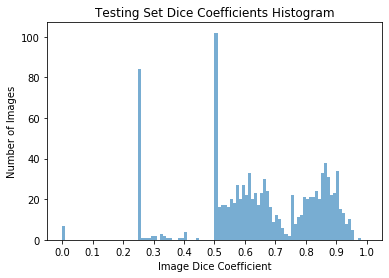

The maximum dice coefficient an image received was 0.9746044874191284
The minimum dice coefficient an image received was 1.108586529866007e-12


In [ ]:
#Plot the distribution of dice coefficients calculated for each image
plt.hist(test_image_dices, bins=100, range=(0, 1), alpha = 0.6)
plt.title('Testing Set Dice Coefficients Histogram')
plt.xlabel('Image Dice Coefficient')
plt.xticks([x/100 for x in range(0,101,10)])
plt.ylabel('Number of Images')
plt.show()

print("The maximum dice coefficient an image received was", max(test_image_dices))
print("The minimum dice coefficient an image received was", min(test_image_dices))

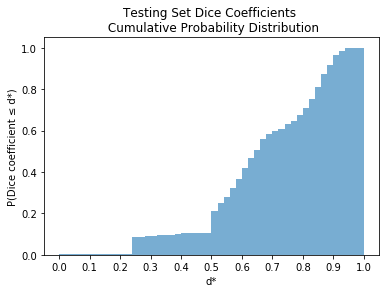

In [ ]:
plt.hist(test_image_dices, bins=50, range=(0, 1), alpha = 0.6, 
         cumulative = True, density = True, label = "Actual Dice Cumulative Probability Distribution")
#plt.hist(np.random.normal(size = len(test_image_dices)), 
#         bins=50, range=(0, 1), cumulative = True, density = True, facecolor="none", 
#        edgecolor='black', label = "Normal Cumulative Probability Distribution")

plt.title('Testing Set Dice Coefficients \n Cumulative Probability Distribution')
plt.xlabel('d*')
plt.xticks([x/100 for x in range(0,101,10)])
plt.ylabel('P(Dice coefficient ≤ d*)')
#plt.legend(loc='best')
plt.show()


In [ ]:
#Save images of predictions on the Kaggle-provided testing set (ground-truth unknown)
!unzip -q test_images.zip -d test_images

os.makedirs("/content/test2_images_highlighted_predicted/")
for imgName in os.listdir("/content/test_images/"):
    img_file, _, _ = predictionFromModel(model, "/content/test_images/" + imgName)
    os.chdir("/content/test2_images_highlighted_predicted/")
    img_file.save("Highlighted_Predicted " + imgName)

#zip the files
os.chdir("/content/")
shutil.make_archive("test2_images_highlighted_predicted", 'zip', "/content/test2_images_highlighted_predicted")


'/content/test2_images_highlighted_predicted.zip'

In [ ]:
#Predictions on Kaggle-provided testing set
from IPython.display import HTML

HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vSXfsyXhx-CdUfKhjA2-sQpTc3aXWabQhNKYHtpPvY-cNnZdx6lLkdxPjZwYObveAnCwAT_iBxHeL_v/embed?start=true&loop=false&delayms=3000" frameborder="0" width="800" height="600" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

In [ ]:
#Final Presentation
HTML('<iframe src="https://drive.google.com/file/d/146nJ5Bw1bLnW3KorK6z7_8N33bHEN36M/preview" width="800" height="600"></iframe>')